In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from pathlib import Path

print("Starting emissions data processing...")

# ================================
# Step 1: Load CEMS data for facility filtering
# ================================

print("Loading CEMS facilities data...")
emissions_cems = pd.read_csv('../data/2023_annual_emissions_CEMS.csv')
cems_plants = set(emissions_cems['Facility ID'].unique())  # Convert to set for faster lookups
print(f"Loaded {len(cems_plants)} unique CEMS facility IDs")

# ================================
# Step 2: Load and filter FF10_POINT data based on CEMS facilities
# ================================

# Path to your specific FF10_POINT format file
egu_file_path = "../data/raw/point/2022hc_cb6_22m/inputs/ptegu/egu_cems_2022_POINT_20240615_2022cems_stackfix2_23jul2024_v0.csv"

print(f"Reading EGU CEMS data from {egu_file_path}...")

# Count number of header lines to skip
with open(egu_file_path, 'r') as f:
    header_lines = 0
    for line in f:
        if line.startswith('#'):
            header_lines += 1
        else:
            break

# Read the FF10_POINT file, skipping header comments
egu_df = pd.read_csv(egu_file_path, skiprows=header_lines, low_memory=False)
print(f"EGU data loaded. Shape: {egu_df.shape}")

# Filter to keep only rows where oris_facility_code is in CEMS plants
filtered_egu = []
matched_facility_ids = set()  # Track unique facility IDs that match CEMS

for idx, row in egu_df.iterrows():
    try:
        # Get ORIS facility code
        oris_code = row.get('oris_facility_code', None)
        facility_id = row.get('facility_id', None)
        
        # Skip if either is missing
        if oris_code is None or pd.isna(oris_code) or facility_id is None or pd.isna(facility_id):
            continue
            
        # Try to convert ORIS code to integer
        try:
            oris_code_int = int(str(oris_code).strip())
            # Check if in CEMS plants
            if oris_code_int in cems_plants:
                filtered_egu.append(row)
                matched_facility_ids.add(str(facility_id).strip())
        except (ValueError, TypeError):
            continue
    except Exception as e:
        if idx % 5000 == 0:  # Limit error output
            print(f"Error processing EGU row {idx}: {e}")

print(f"Found {len(matched_facility_ids)} unique facility IDs matching CEMS plants")

# ================================
# Step 3: Load and filter NEI data based on matched facility IDs
# ================================

# Path to your NEI facility summary CSV file
nei_file_path = "../data/raw/2021_NEI_Facility_summary.csv"
print(f"Reading NEI data from {nei_file_path}...")

# Read the NEI CSV file
try:
    nei_df = pd.read_csv(nei_file_path, sep=',', low_memory=False)
    print("NEI file read with comma delimiter")
except:
    try:
        nei_df = pd.read_csv(nei_file_path, low_memory=False)
        print("NEI file read with default delimiter")
    except:
        nei_df = pd.read_csv(nei_file_path, sep=None, engine='python', low_memory=False)
        print("NEI file read with automatic delimiter detection")

print(f"NEI data loaded. Shape: {nei_df.shape}")

# Filter NEI data to keep only rows with eis facility id matching matched_facility_ids
filtered_nei = []
for idx, row in nei_df.iterrows():
    try:
        eis_id = row.get('eis facility id', None)
        if eis_id is not None and not pd.isna(eis_id) and str(eis_id).strip() in matched_facility_ids:
            filtered_nei.append(row)
    except Exception as e:
        if idx % 10000 == 0:  # Limit error output
            print(f"Error processing NEI row {idx}: {e}")

print(f"Filtered NEI data to {len(filtered_nei)} rows matching facility IDs")

# Convert filtered_nei list to DataFrame
filtered_nei_df = pd.DataFrame(filtered_nei)

# ================================
# Step 4: Process filtered NEI data to create GeoDataFrame for InMAP
# ================================

# Create output directory if it doesn't exist
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Convert emissions to metric tonnes
def convert_to_tonnes(row):
    if row['emissions uom'] == 'LB':
        return float(row['total emissions']) * 0.000453592  # Convert pounds to metric tonnes
    elif row['emissions uom'] == 'TON':
        return float(row['total emissions']) * 0.90718474  # Convert short tons to metric tonnes
    return float(row['total emissions'])  # Already in metric tonnes

# Categorize pollutants
def categorize_pollutant(row):
    pollutant = str(row['pollutant code']).upper()
    pollutant_desc = str(row['pollutant desc']).upper() if 'pollutant desc' in row else ""

    if pollutant == 'VOC' or 'VOLATILE ORGANIC' in pollutant_desc:
        return 'VOC'
    elif pollutant in ['NOX', 'NO', 'NO2'] or ('NITROGEN' in pollutant_desc and 'OXIDE' in pollutant_desc):
        return 'NOx'
    elif pollutant == 'NH3' or 'AMMONIA' in pollutant_desc:
        return 'NH3'
    elif pollutant in ['SO2', 'SO4'] or 'SULFUR' in pollutant_desc:
        return 'SOx'
    elif 'PM25' in pollutant or 'PM2.5' in pollutant_desc or 'PM2_5' in pollutant:
        return 'PM2_5'
    elif pollutant == 'CO2':
        return 'CO2'
    return 'Other'

# Apply the conversion and categorization functions
print("Processing emissions data...")

# Make sure required columns exist
required_columns = ['emissions uom', 'total emissions', 'pollutant code', 'pollutant desc', 
                    'site latitude', 'site longitude']
for col in required_columns:
    if col not in filtered_nei_df.columns:
        print(f"Warning: Missing required column '{col}' in NEI data")

# Add emissions_tonnes column
filtered_nei_df['emissions_tonnes'] = filtered_nei_df.apply(convert_to_tonnes, axis=1)

# Add pollutant_category column
filtered_nei_df['pollutant_category'] = filtered_nei_df.apply(categorize_pollutant, axis=1)

# Ensure latitude and longitude exist before creating geometry
filtered_nei_df['geometry'] = filtered_nei_df.apply(
    lambda row: Point(row['site longitude'], row['site latitude']) 
    if pd.notna(row['site longitude']) and pd.notna(row['site latitude']) 
    else None, axis=1
)

# Drop rows with invalid geometries
filtered_nei_df = filtered_nei_df.dropna(subset=['geometry'])

# ================================
# Step 5: Aggregate Data by Facility and Create GeoDataFrame
# ================================

# Group by facility and pollutant category
facility_emissions = filtered_nei_df.groupby([
    'eis facility id', 'site name', 'state', 'site latitude', 'site longitude', 
    'primary naics code', 'pollutant_category'
])['emissions_tonnes'].sum().reset_index()

# Convert to wide format with pollutants as columns
facility_wide = facility_emissions.pivot_table(
    index=['eis facility id', 'site name', 'state', 'site latitude', 'site longitude', 
           'primary naics code'],
    columns='pollutant_category', 
    values='emissions_tonnes',
    fill_value=0
).reset_index()

# Ensure all required pollutant columns exist
for cat in ['VOC', 'NOx', 'NH3', 'SOx', 'PM2_5', 'CO2']:
    if cat not in facility_wide.columns:
        facility_wide[cat] = 0

# Create geometry column
facility_wide['geometry'] = facility_wide.apply(
    lambda row: Point(row['site longitude'], row['site latitude']), 
    axis=1
)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(
    facility_wide, 
    geometry='geometry',
    crs='epsg:4269'  # Set coordinate reference system
)

print(f"Created GeoDataFrame with {len(gdf)} facilities")

# Filter for power plants (EGUs) using NAICS codes
egu_naics = ['2211', '221111', '221112', '221113', '221114', '221115', 
             '221116', '221117', '221118', '221121', '221122']

# Create a mask for power plants
is_power_plant = gdf['primary naics code'].astype(str).apply(
    lambda x: any(x.startswith(prefix) for prefix in egu_naics) if not pd.isna(x) else False
)

# Apply the mask
egu_gdf = gdf[is_power_plant].copy()
print(f"Filtered to {len(egu_gdf)} power plant facilities")

# ================================
# Step 6: Add stack parameters
# ================================

# Since NEI data might not have stack parameters, we'll use defaults or extract from EGU data if possible
# Typical values for power plants
default_stack_height = 50.0  # meters
default_stack_diam = 5.0     # meters
default_stack_temp = 400.0   # Kelvin
default_stack_velocity = 20.0  # m/s

# Add stack parameter columns with default values
egu_gdf['height'] = default_stack_height
egu_gdf['diam'] = default_stack_diam
egu_gdf['temp'] = default_stack_temp
egu_gdf['velocity'] = default_stack_velocity

# ================================
# Step 7: Save Processed Data
# ================================

# Save all facilities data
all_facilities_output = f"{output_dir}/processed_all_facilities_emissions.gpkg"
gdf.to_file(all_facilities_output, driver="GPKG")
print(f"Saved all facilities data to {all_facilities_output}")

# Save power plant data
egu_output_file = f"{output_dir}/processed_egu_emissions.gpkg"
egu_gdf.to_file(egu_output_file, driver="GPKG")
print(f"Saved processed power plant data to {egu_output_file}")

# Create a version with just the InMAP required columns
inmap_columns = ["VOC", "NOx", "NH3", "SOx", "PM2_5", "height", "diam", "temp", "velocity", "geometry"]
inmap_egu = egu_gdf[inmap_columns].copy()

# Save InMAP-compatible version
inmap_output_file = f"{output_dir}/processed_emissions_for_inmap.gpkg"
inmap_egu.to_file(inmap_output_file, driver="GPKG")
print(f"Saved InMAP-formatted emissions data to {inmap_output_file}")

print("\nProcessing complete! Ready to use with run_sr function.")
print("Example: resultsISRM = run_sr(inmap_egu, model='isrm', emis_units='tons/year')")

Starting emissions data processing...
Loading CEMS facilities data...
Loaded 1343 unique CEMS facility IDs
Reading EGU CEMS data from ../data/raw/point/2022hc_cb6_22m/inputs/ptegu/egu_cems_2022_POINT_20240615_2022cems_stackfix2_23jul2024_v0.csv...
EGU data loaded. Shape: (126465, 77)
Found 1106 unique facility IDs matching CEMS plants
Reading NEI data from ../data/raw/2021_NEI_Facility_summary.csv...
NEI file read with comma delimiter
NEI data loaded. Shape: (2005169, 33)
Filtered NEI data to 46417 rows matching facility IDs
Processing emissions data...
Created GeoDataFrame with 1097 facilities
Filtered to 1069 power plant facilities
Saved all facilities data to ../data/processed/processed_all_facilities_emissions.gpkg
Saved processed power plant data to ../data/processed/processed_egu_emissions.gpkg
Saved InMAP-formatted emissions data to ../data/processed/processed_emissions_for_inmap.gpkg

Processing complete! Ready to use with run_sr function.
Example: resultsISRM = run_sr(inmap_eg

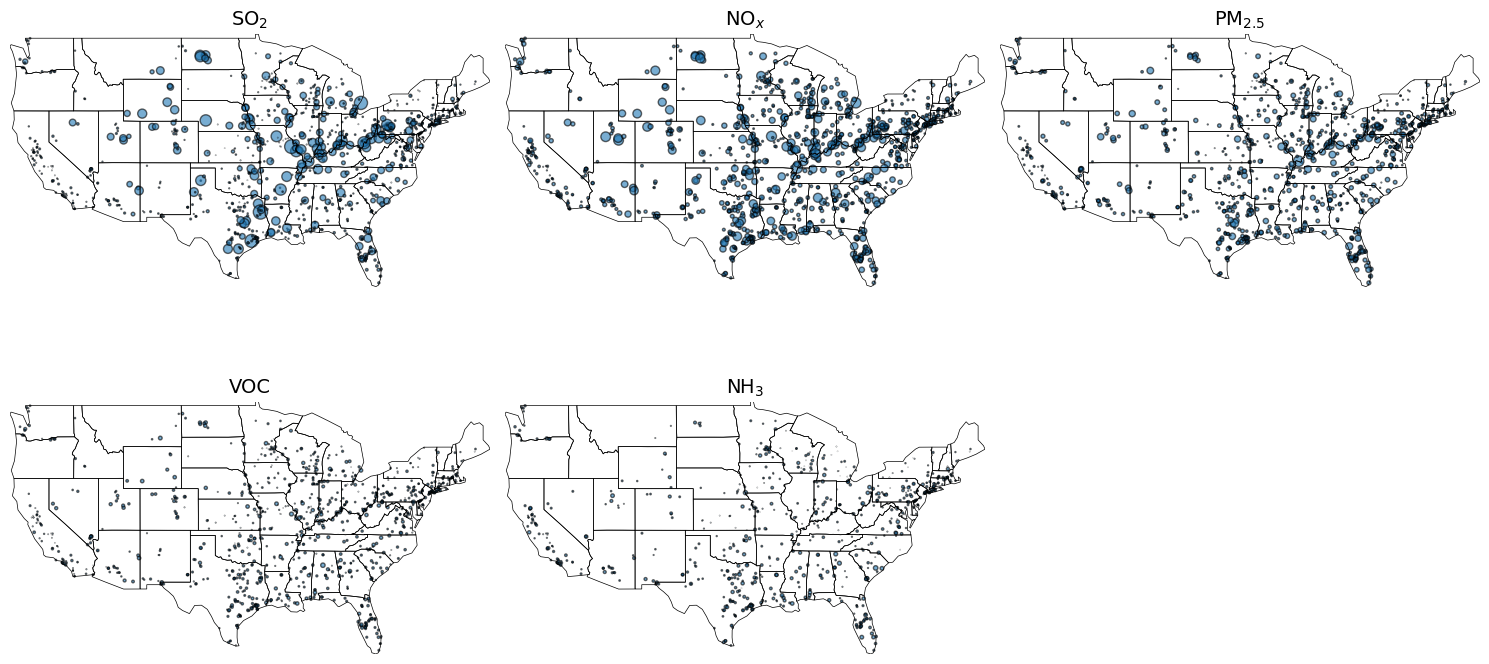

In [16]:
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

# 1. Load & Convert CRS
us_states = gpd.read_file("../data/raw/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp")
us_states = us_states[~us_states['name'].isin(['Alaska', 'Hawaii'])]
us_states = us_states.to_crs(epsg=4269)  # match egu_gdf if egu_gdf is in EPSG:4269

egu_gdf = egu_gdf.to_crs(epsg=4269)     # ensure egu_gdf also in EPSG:4269

# 2. Pollutants
pols = ["SOx", "NOx", "PM2_5", "VOC", "NH3"]
pol_names = ["SO$_2$", "NO$_x$", "PM$_{2.5}$", "VOC", "NH$_3$"]

# 3. Plot
fig, axes = plt.subplots(figsize=(15, 8), nrows=2, ncols=3, sharex=True, sharey=True)
#plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.01, hspace=0.01)

minx, miny, maxx, maxy = us_states.total_bounds

for i, ax in enumerate(axes.flat):
    if i < len(pols):
        us_states.boundary.plot(ax=ax, color="black", linewidth=0.5)
        egu_gdf.plot(
            ax=ax,
            markersize=egu_gdf[pols[i]]**0.5 / 2,
            alpha=0.6,
            edgecolor='black'
        )
        ax.set_title(pol_names[i], fontsize=14)

        
        # Zoom to lower 48
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

# 4. Remove the last unused subplot
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

In [7]:
# Below are the helper functions for the run_sr function
import time
import numpy as np
import zarr
from shapely.geometry import Polygon, Point
import pandas as pd
import geopandas as gpd
import s3fs

def rect(i, w, s, e, n):
    x = [w[i], e[i], e[i], w[i], w[i]]
    y = [s[i], s[i], n[i], n[i], s[i]]
    return x, y

def poly(sr):
    ret = []
    w = sr["W"][:]
    s = sr["S"][:]
    e = sr["E"][:]
    n = sr["N"][:]
    for i in range(52411):
        x, y = rect(i, w, s, e, n)
        ret.append(Polygon([[x[0],y[0]],[x[1],y[1]],[x[2],y[2]],
                            [x[3],y[3]],[x[4],y[4]]]))
    return ret

# Define the run_sr function
def run_sr(emis, model, emis_units="tons/year"):
    start = time.time()
    
    # Load spatial receptor grid (SR)
    url = 's3://inmap-model/isrm_v1.2.1.zarr/'
    fs = s3fs.S3FileSystem(anon=True, client_kwargs={"region_name": "us-east-2"})
    sr = zarr.open(
        store=url,
        mode="r",
        storage_options={"anon": True, "client_kwargs": {"region_name": "us-east-2"}}
    )   

    # Build the grid geometry
    p = poly(sr)
    print("Making polygons as geometry.")

    # Create grid GeoDataFrame
    df = pd.DataFrame({'Location': range(52411)})
    gdf = gpd.GeoDataFrame(df, geometry=p, crs="+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1")
    
    # Ensure emis has CRS set correctly
    if emis.crs is None:
        print("Warning: emis CRS is None. Assigning default CRS (WGS84).")
        emis = emis.set_crs("EPSG:4326")

    # Convert emissions to match grid CRS
    emis = emis.to_crs(gdf.crs)

    # Spatial join (match emissions to grid)
    join_right_df = gdf.sjoin(emis, how="right")

    # Debugging: Print missing locations
    missing_count = join_right_df.Location.isna().sum()
    print(f"Finished joining dataframes. Missing locations: {missing_count}")

    # Drop NaN locations if any exist
    join_right_df = join_right_df.dropna(subset=["Location"])
    
    index = join_right_df.Location.astype(int).tolist()  # Ensure integer type

    # Get unique indices for emissions
    ppl = np.unique(index).tolist()

    # Create dictionary for mapping locations to index
    dictionary = {ppl[i]: i for i in range(len(ppl))}

    # Load Source-Receptor (SR) matrix data
    SOA = sr['SOA'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("SOA data allocated.")
    pNO3 = sr['pNO3'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNO3 data allocated.")
    pNH4 = sr['pNH4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNH4 data allocated.")
    pSO4 = sr['pSO4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pSO4 data allocated.")
    PM25 = sr['PrimaryPM25'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("PrimaryPM25 data allocated.")

    # Initialize output data arrays
    SOA_data, pNO3_data, pNH4_data, pSO4_data, PM25_data = 0.0, 0.0, 0.0, 0.0, 0.0

    # Calculate pollution data using emissions
    for i in range(len(index)):
        loc_idx = dictionary[index[i]]  # Get correct index
        SOA_data += SOA[0, loc_idx, :] * emis.VOC.iloc[i]
        pNO3_data += pNO3[0, loc_idx, :] * emis.NOx.iloc[i]
        pNH4_data += pNH4[0, loc_idx, :] * emis.NH3.iloc[i]
        pSO4_data += pSO4[0, loc_idx, :] * emis.SOx.iloc[i]
        PM25_data += PM25[0, loc_idx, :] * emis.PM2_5.iloc[i]

    data = SOA_data + pNO3_data + pNH4_data + pSO4_data + PM25_data

    print("Accessing data.")

    # Apply emission unit conversion factor
    fact = 28766.639 if emis_units == "tons/year" else 1

    # Compute final pollution metrics
    TotalPM25 = fact * data
    TotalPop = sr['TotalPop'][0:52411]
    MortalityRate = sr['MortalityRate'][0:52411]
    deathsK = (np.exp(np.log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.04658 * MortalityRate / 100000 * 1.02523
    deathsL = (np.exp(np.log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.04658 * MortalityRate / 100000 * 1.02523

    # Create output GeoDataFrame
    ret = gpd.GeoDataFrame(pd.DataFrame({
        'SOA': fact * SOA_data,
        'pNO3': fact * pNO3_data,
        'pNH4': fact * pNH4_data,
        'pSO4': fact * pSO4_data,
        'PrimaryPM25': fact * PM25_data,
        'TotalPM25': TotalPM25,
        'deathsK': deathsK,
        'deathsL': deathsL
    }), geometry=p[:52411])

    print(f"Finished ({time.time() - start:.0f} seconds)")
    return ret

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.gridspec as gridspec
from pathlib import Path

# ================================
# Step 1: Load the necessary data
# ================================

# Load the InMAP-formatted emissions data for the SR model
print("Loading InMAP emissions data...")
inmap_egu = gpd.read_file("../data/processed/processed_emissions_for_inmap.gpkg")

# Load the original EGU data with ORIS codes
print("Loading EGU data with facility IDs...")
egu_with_ids = gpd.read_file("../data/processed/processed_egu_emissions.gpkg")

# Load CEMS data for CO2 emissions
print("Loading CEMS data for climate damages...")
cems_data = pd.read_csv('../data/2023_annual_emissions_CEMS.csv')

# Check CEMS data structure
print(f"CEMS data shape: {cems_data.shape}")
print("CEMS data columns:", cems_data.columns.tolist())

# ================================
# Step 2: Clean and prepare CEMS data
# ================================

# Clean up column names - remove any whitespace
cems_data.columns = [col.strip() for col in cems_data.columns]

# Rename columns for consistency (based on the sample you provided)
column_mapping = {
    'Facility ID': 'oris_facility_code',
    'CO2 Mass (short tons)': 'co2_short_tons',
    'Facility Name': 'facility_name',
    'State': 'state',
    'Year': 'year'
}

# Rename columns if they exist
for old_col, new_col in column_mapping.items():
    if old_col in cems_data.columns:
        cems_data.rename(columns={old_col: new_col}, inplace=True)

# Ensure CO2 column is numeric
if 'co2_short_tons' in cems_data.columns:
    cems_data['co2_short_tons'] = pd.to_numeric(cems_data['co2_short_tons'], errors='coerce')
else:
    print("Warning: CO2 Mass column not found in CEMS data. Using a proxy if available.")
    # If CO2 column is missing, try to use Heat Input as a proxy, which is common in CEMS data
    if 'Heat Input (mmBtu)' in cems_data.columns:
        # Approximate conversion: ~0.1 short tons CO2 per mmBtu (varies by fuel type)
        cems_data['co2_short_tons'] = pd.to_numeric(cems_data['Heat Input (mmBtu)'], errors='coerce') * 0.1
    
# Ensure facility ID is string type for matching
cems_data['oris_facility_code'] = cems_data['oris_facility_code'].astype(str)

# Aggregate CO2 by facility ID
co2_by_facility = cems_data.groupby('oris_facility_code')['co2_short_tons'].sum().reset_index()
print(f"Found CO2 data for {len(co2_by_facility)} facilities from CEMS")

# ================================
# Step 3: Run the Source-Receptor model with the InMAP-formatted data
# ================================

print("Running Source-Receptor model...")
resultsISRM = run_sr(inmap_egu, model="isrm", emis_units="tons/year")

# Explicitly set CRS for resultsISRM if it's not defined
if resultsISRM.crs is None:
    print("Setting CRS for resultsISRM to EPSG:4269")
    resultsISRM = resultsISRM.set_crs("epsg:4269", allow_override=True)
else:
    print(f"resultsISRM has CRS: {resultsISRM.crs}")

# ================================
# Step 4: Prepare county-level data for visualization
# ================================

# Load county boundaries
print("Loading county boundaries...")
us_counties = gpd.read_file("../data/raw/cb_2018_us_county_500k/cb_2018_us_county_500k.shp")

# Convert counties to match emissions data CRS
target_crs = "epsg:4269"  # NAD83, commonly used for US data
print(f"Converting all data to common CRS: {target_crs}")

# Ensure all datasets use the same CRS
resultsISRM = resultsISRM.to_crs(target_crs)
us_counties = us_counties.to_crs(target_crs)
egu_with_ids = egu_with_ids.to_crs(target_crs)

# Perform spatial join to assign each grid cell to a county
print("Joining health impacts to counties...")
results_county = resultsISRM.sjoin(us_counties, how="left", predicate="intersects")

# Aggregate health impacts by county
county_summary = results_county.groupby("NAME").agg({
    "SOA": "sum",
    "pNO3": "sum",
    "pNH4": "sum",
    "pSO4": "sum",
    "PrimaryPM25": "sum",
    "TotalPM25": "sum",
    "deathsK": "sum",
    "deathsL": "sum"
}).reset_index()

# Merge summary with county shapefile for visualization
us_counties = us_counties.merge(county_summary, on="NAME", how="left")

# Exclude Alaska, Hawaii, and Puerto Rico
us_counties = us_counties[~us_counties['STATEFP'].isin(["02", "15", "72"])]

# ================================
# Step 5: Calculate health damages
# ================================

# Value of a Statistical Life in dollars
VSL = 13.2e6  # $13.2 million per life

# Calculate health damages for each county
us_counties['HealthDamages'] = us_counties['deathsK'] * VSL

# Handle NaN values
us_counties.loc[:, 'HealthDamages'] = us_counties['HealthDamages'].fillna(0)

# ================================
# Step 6: Calculate climate damages using CEMS CO2 data
# ================================

# Create a mapping from ORIS codes to geometries for spatial joining
print("Mapping CEMS CO2 data to counties...")

# Ensure oris_facility_code is in egu_with_ids
if 'oris_facility_code' not in egu_with_ids.columns:
    print("Warning: oris_facility_code column not found in EGU data")
    # Try to find alternative column that might contain ORIS codes
    potential_columns = ['eis facility id', 'facility_id', 'oris_code']
    for col in potential_columns:
        if col in egu_with_ids.columns:
            print(f"Using {col} as proxy for ORIS facility code")
            egu_with_ids['oris_facility_code'] = egu_with_ids[col].astype(str)
            break
    else:
        print("No suitable ORIS facility code column found. Creating synthetic data.")
        # Create synthetic column if no suitable column found
        egu_with_ids['oris_facility_code'] = range(1, len(egu_with_ids) + 1)
        egu_with_ids['oris_facility_code'] = egu_with_ids['oris_facility_code'].astype(str)

# Convert ORIS code to string in both datasets
egu_with_ids['oris_facility_code'] = egu_with_ids['oris_facility_code'].astype(str)
co2_by_facility['oris_facility_code'] = co2_by_facility['oris_facility_code'].astype(str)

# Merge CO2 data with EGU data
egu_with_co2 = egu_with_ids.merge(co2_by_facility, on='oris_facility_code', how='left')

# Convert short tons to metric tonnes
conversion_factor = 0.90718474  # short tons to metric tonnes
egu_with_co2['co2_metric_tonnes'] = egu_with_co2['co2_short_tons'] * conversion_factor

# Fill missing values with estimated CO2 if available in the original dataset
if 'CO2' in egu_with_co2.columns:
    egu_with_co2.loc[egu_with_co2['co2_metric_tonnes'].isna(), 'co2_metric_tonnes'] = egu_with_co2.loc[egu_with_co2['co2_metric_tonnes'].isna(), 'CO2']

# Social Cost of Carbon (SCC) in dollars per metric tonne
SCC = 51  # $51 per tonne of CO2 (based on EPA estimates)

# Calculate climate damages
egu_with_co2['ClimateDamages'] = egu_with_co2['co2_metric_tonnes'] * SCC

# Spatial join to assign facilities to counties
print("Assigning facilities to counties...")
facility_counties = egu_with_co2.sjoin(us_counties[['GEOID', 'geometry']], how="inner", predicate="within")

# Aggregate climate damages by county
climate_summary = facility_counties.groupby('GEOID')['ClimateDamages'].sum().reset_index()
print(f"Calculated climate damages for {len(climate_summary)} counties")

# Merge climate damages with county data
us_counties = us_counties.merge(climate_summary[['GEOID', 'ClimateDamages']], on='GEOID', how='left')
us_counties['ClimateDamages'] = us_counties['ClimateDamages'].fillna(0)

# Calculate total damages (health + climate)
us_counties['TotalDamages'] = us_counties['HealthDamages'] + us_counties['ClimateDamages']

# ================================
# Step 7: Create dual-panel visualization
# ================================

# Define bins and colors for damages
bins = [0, 1e6, 5e6, 10e6, 50e6, 100e6, 500e6, 1e9, 5e9, float("inf")]
colors = ['#ffedea', '#ffcec5', '#ffad9f', '#ff7f66', '#ff4d33', 
          '#ff1a00', '#cc1600', '#990f00', '#660a00']

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Bin the health and total damages data
us_counties['HealthDamages_Binned'] = pd.cut(us_counties['HealthDamages'], bins=bins, labels=False, include_lowest=True)
us_counties['TotalDamages_Binned'] = pd.cut(us_counties['TotalDamages'], bins=bins, labels=False, include_lowest=True)

# Create figure with two panels
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Left panel - Health Damages
ax1 = plt.subplot(gs[0])
us_counties.plot(column='HealthDamages_Binned', cmap=cmap, linewidth=0.3, edgecolor="black", 
                 ax=ax1, legend=False)
ax1.set_title('Health Damages from Power Plant Emissions', fontsize=16)
ax1.axis('off')
ax1.set_aspect(1.3)
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)

# Calculate total damages across all counties
total_health = us_counties['HealthDamages'].sum() / 1e9  # billions of dollars
total_climate = us_counties['ClimateDamages'].sum() / 1e9  # billions of dollars
total_combined = us_counties['TotalDamages'].sum() / 1e9  # billions of dollars

# Add text annotation with total health damages
ax1.text(0.05, 0.05, f'Total Health Damages: ${total_health:.2f} billion', 
         transform=ax1.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Right panel - Total Damages (Health + Climate)
ax2 = plt.subplot(gs[1])
us_counties.plot(column='TotalDamages_Binned', cmap=cmap, linewidth=0.3, edgecolor="black", 
                 ax=ax2, legend=False)
ax2.set_title('Total Damages (Health + Climate) from Power Plant Emissions', fontsize=16)
ax2.axis('off')
ax2.set_aspect(1.3)
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)

# Add text annotation with total combined damages
ax2.text(0.05, 0.05, 
         f'Total Combined Damages: ${total_combined:.2f} billion\n' +
         f'Climate Damages: ${total_climate:.2f} billion\n' + 
         f'Using CEMS CO2 data for climate impacts', 
         transform=ax2.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Create formatted legend labels
legend_labels = [
    '$0 - $1M', 
    '$1M - $5M', 
    '$5M - $10M', 
    '$10M - $50M', 
    '$50M - $100M', 
    '$100M - $500M', 
    '$500M - $1B', 
    '$1B - $5B', 
    '$5B+'
]

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color=colors[i], label=legend_labels[i]) 
    for i in range(len(legend_labels))
]

# Add the custom legend to the figure
fig.legend(handles=legend_patches, title="Damages ($)", 
           loc="lower center", ncol=len(legend_labels), bbox_to_anchor=(0.5, 0.02))

# Adjust layout
plt.tight_layout(rect=[0, 0.07, 1, 0.98])
plt.suptitle('Comparison of Health vs. Combined (Health + Climate) Damages from Power Plant Emissions', fontsize=18, y=0.98)

# Create output directory if it doesn't exist
output_dir = Path("../figures")
output_dir.mkdir(parents=True, exist_ok=True)

# Save the figure
plt.savefig("../figures/health_climate_damages_comparison.png", dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

print("Visualization complete!")

Loading county boundaries...
Converting all data to common CRS: epsg:4269
Joining health impacts to counties...
Mapping CEMS CO2 data to counties...
Using eis facility id as proxy for ORIS facility code
Assigning facilities to counties...
Calculated climate damages for 664 counties


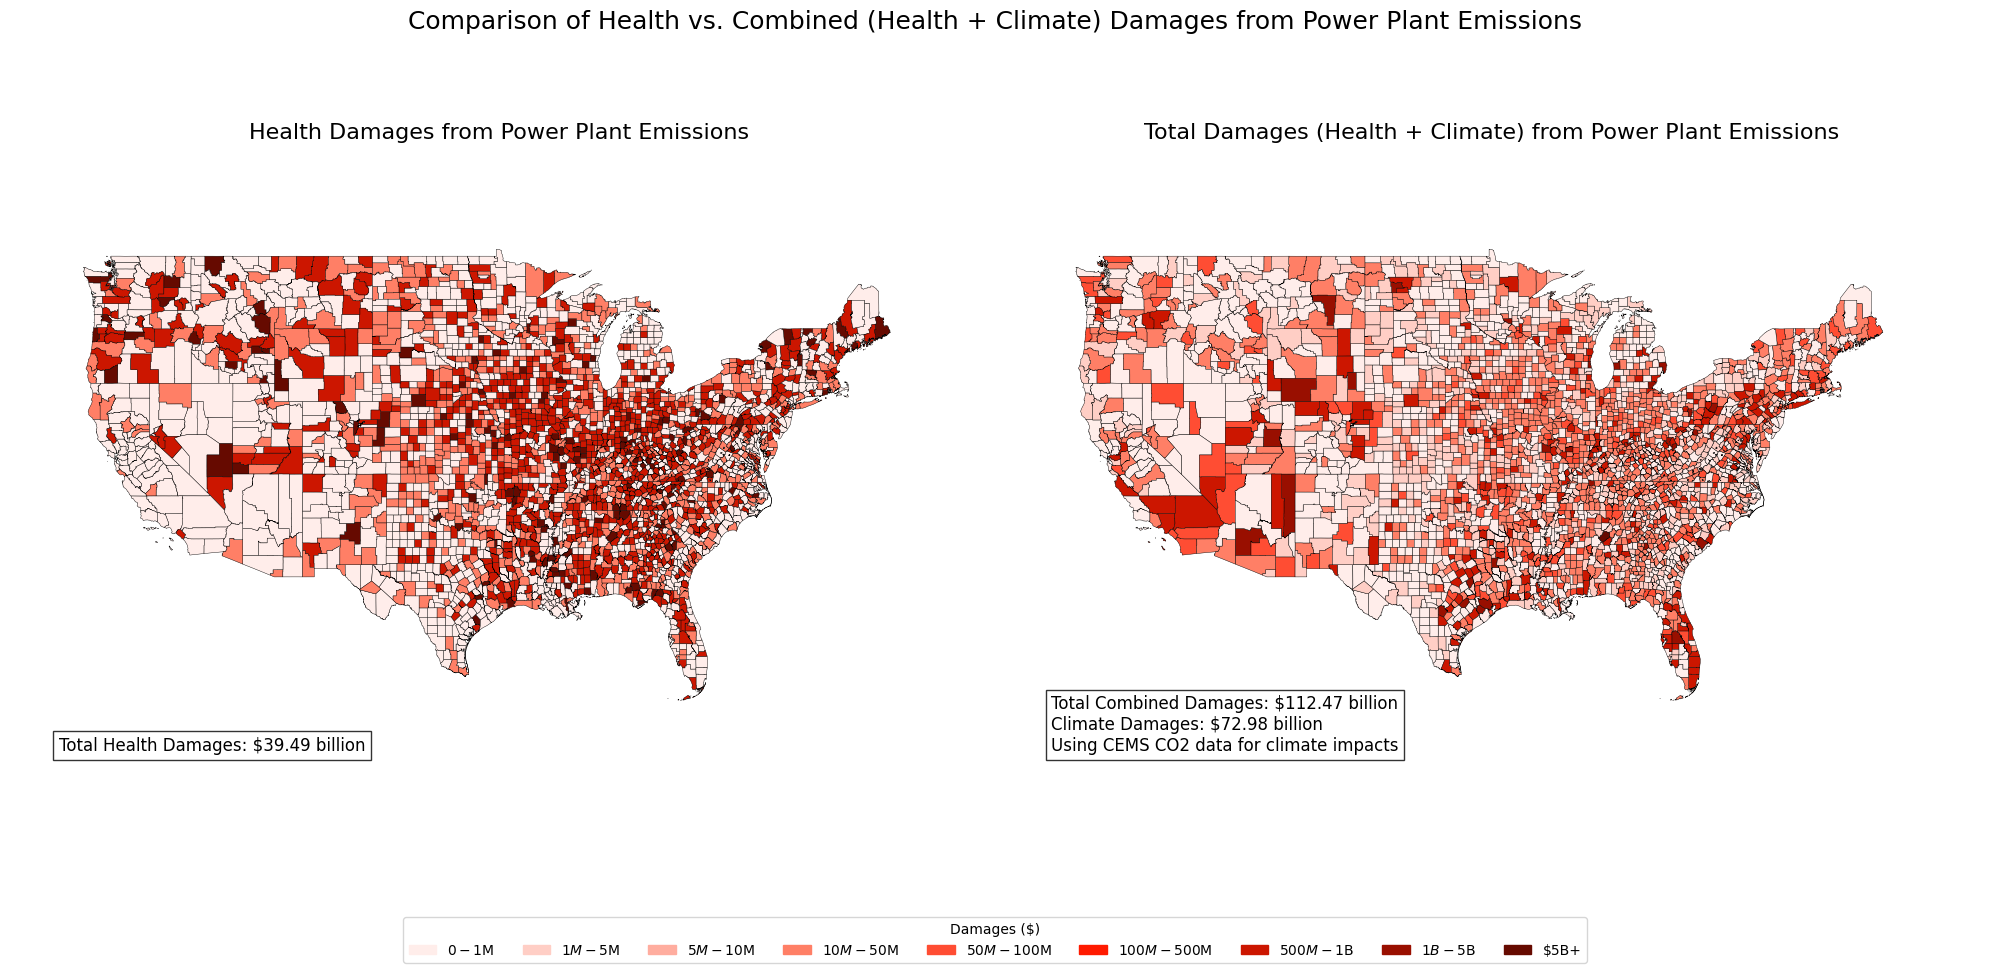

Visualization complete!


In [9]:
# ================================
# Step 4: Prepare county-level data for visualization
# ================================

# Load county boundaries
print("Loading county boundaries...")
us_counties = gpd.read_file("../data/raw/cb_2018_us_county_500k/cb_2018_us_county_500k.shp")

# Convert counties to match emissions data CRS
target_crs = "epsg:4269"  # NAD83, commonly used for US data
print(f"Converting all data to common CRS: {target_crs}")

# Ensure all datasets use the same CRS
resultsISRM = resultsISRM.to_crs(target_crs)
us_counties = us_counties.to_crs(target_crs)
egu_with_ids = egu_with_ids.to_crs(target_crs)

# Perform spatial join to assign each grid cell to a county
print("Joining health impacts to counties...")
results_county = resultsISRM.sjoin(us_counties, how="left", predicate="intersects")

# Aggregate health impacts by county
county_summary = results_county.groupby("NAME").agg({
    "SOA": "sum",
    "pNO3": "sum",
    "pNH4": "sum",
    "pSO4": "sum",
    "PrimaryPM25": "sum",
    "TotalPM25": "sum",
    "deathsK": "sum",
    "deathsL": "sum"
}).reset_index()

# Merge summary with county shapefile for visualization
us_counties = us_counties.merge(county_summary, on="NAME", how="left")

# Exclude Alaska, Hawaii, and Puerto Rico
us_counties = us_counties[~us_counties['STATEFP'].isin(["02", "15", "72"])]

# ================================
# Step 5: Calculate health damages
# ================================

# Value of a Statistical Life in dollars
VSL = 13.2e6  # $13.2 million per life

# Calculate health damages for each county
us_counties['HealthDamages'] = us_counties['deathsK'] * VSL

# Handle NaN values
us_counties.loc[:, 'HealthDamages'] = us_counties['HealthDamages'].fillna(0)

# ================================
# Step 6: Calculate climate damages using CEMS CO2 data
# ================================

# Create a mapping from ORIS codes to geometries for spatial joining
print("Mapping CEMS CO2 data to counties...")

# Ensure oris_facility_code is in egu_with_ids
if 'oris_facility_code' not in egu_with_ids.columns:
    print("Warning: oris_facility_code column not found in EGU data")
    # Try to find alternative column that might contain ORIS codes
    potential_columns = ['eis facility id', 'facility_id', 'oris_code']
    for col in potential_columns:
        if col in egu_with_ids.columns:
            print(f"Using {col} as proxy for ORIS facility code")
            egu_with_ids['oris_facility_code'] = egu_with_ids[col].astype(str)
            break
    else:
        print("No suitable ORIS facility code column found. Creating synthetic data.")
        # Create synthetic column if no suitable column found
        egu_with_ids['oris_facility_code'] = range(1, len(egu_with_ids) + 1)
        egu_with_ids['oris_facility_code'] = egu_with_ids['oris_facility_code'].astype(str)

# Convert ORIS code to string in both datasets
egu_with_ids['oris_facility_code'] = egu_with_ids['oris_facility_code'].astype(str)
co2_by_facility['oris_facility_code'] = co2_by_facility['oris_facility_code'].astype(str)

# Merge CO2 data with EGU data
egu_with_co2 = egu_with_ids.merge(co2_by_facility, on='oris_facility_code', how='left')

# Convert short tons to metric tonnes
conversion_factor = 0.90718474  # short tons to metric tonnes
egu_with_co2['co2_metric_tonnes'] = egu_with_co2['co2_short_tons'] * conversion_factor

# Fill missing values with estimated CO2 if available in the original dataset
if 'CO2' in egu_with_co2.columns:
    egu_with_co2.loc[egu_with_co2['co2_metric_tonnes'].isna(), 'co2_metric_tonnes'] = egu_with_co2.loc[egu_with_co2['co2_metric_tonnes'].isna(), 'CO2']

# Social Cost of Carbon (SCC) in dollars per metric tonne
SCC = 51  # $51 per tonne of CO2 (based on EPA estimates)

# Calculate climate damages
egu_with_co2['ClimateDamages'] = egu_with_co2['co2_metric_tonnes'] * SCC

# Spatial join to assign facilities to counties
print("Assigning facilities to counties...")
facility_counties = egu_with_co2.sjoin(us_counties[['GEOID', 'geometry']], how="inner", predicate="within")

# Aggregate climate damages by county
climate_summary = facility_counties.groupby('GEOID')['ClimateDamages'].sum().reset_index()
print(f"Calculated climate damages for {len(climate_summary)} counties")

# Merge climate damages with county data
us_counties = us_counties.merge(climate_summary[['GEOID', 'ClimateDamages']], on='GEOID', how='left')
us_counties['ClimateDamages'] = us_counties['ClimateDamages'].fillna(0)

# Calculate total damages (health + climate)
us_counties['TotalDamages'] = us_counties['HealthDamages'] + us_counties['ClimateDamages']

# ================================
# Step 7: Create dual-panel visualization
# ================================

# Define bins and colors for damages
bins = [0, 1e6, 5e6, 10e6, 50e6, 100e6, 500e6, 1e9, 5e9, float("inf")]
colors = ['#ffedea', '#ffcec5', '#ffad9f', '#ff7f66', '#ff4d33', 
          '#ff1a00', '#cc1600', '#990f00', '#660a00']

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Bin the health and total damages data
us_counties['HealthDamages_Binned'] = pd.cut(us_counties['HealthDamages'], bins=bins, labels=False, include_lowest=True)
us_counties['TotalDamages_Binned'] = pd.cut(us_counties['TotalDamages'], bins=bins, labels=False, include_lowest=True)

# Create figure with two panels
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Left panel - Health Damages
ax1 = plt.subplot(gs[0])
us_counties.plot(column='HealthDamages_Binned', cmap=cmap, linewidth=0.3, edgecolor="black", 
                 ax=ax1, legend=False)
ax1.set_title('Health Damages from Power Plant Emissions', fontsize=16)
ax1.axis('off')
ax1.set_aspect(1.3)
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)

# Calculate total damages across all counties
total_health = us_counties['HealthDamages'].sum() / 1e9  # billions of dollars
total_climate = us_counties['ClimateDamages'].sum() / 1e9  # billions of dollars
total_combined = us_counties['TotalDamages'].sum() / 1e9  # billions of dollars

# Add text annotation with total health damages
ax1.text(0.05, 0.05, f'Total Health Damages: ${total_health:.2f} billion', 
         transform=ax1.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Right panel - Total Damages (Health + Climate)
ax2 = plt.subplot(gs[1])
us_counties.plot(column='TotalDamages_Binned', cmap=cmap, linewidth=0.3, edgecolor="black", 
                 ax=ax2, legend=False)
ax2.set_title('Total Damages (Health + Climate) from Power Plant Emissions', fontsize=16)
ax2.axis('off')
ax2.set_aspect(1.3)
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)

# Add text annotation with total combined damages
ax2.text(0.05, 0.05, 
         f'Total Combined Damages: ${total_combined:.2f} billion\n' +
         f'Climate Damages: ${total_climate:.2f} billion\n' + 
         f'Using CEMS CO2 data for climate impacts', 
         transform=ax2.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Create formatted legend labels
legend_labels = [
    '$0 - $1M', 
    '$1M - $5M', 
    '$5M - $10M', 
    '$10M - $50M', 
    '$50M - $100M', 
    '$100M - $500M', 
    '$500M - $1B', 
    '$1B - $5B', 
    '$5B+'
]

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color=colors[i], label=legend_labels[i]) 
    for i in range(len(legend_labels))
]

# Add the custom legend to the figure
fig.legend(handles=legend_patches, title="Damages ($)", 
           loc="lower center", ncol=len(legend_labels), bbox_to_anchor=(0.5, 0.02))

# Adjust layout
plt.tight_layout(rect=[0, 0.07, 1, 0.98])
plt.suptitle('Comparison of Health vs. Combined (Health + Climate) Damages from Power Plant Emissions', fontsize=18, y=0.98)

# Create output directory if it doesn't exist
output_dir = Path("../figures")
output_dir.mkdir(parents=True, exist_ok=True)

# Save the figure
plt.savefig("../figures/health_climate_damages_comparison.png", dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

print("Visualization complete!")